# Transfer Learning of YoloV3 with GluonCV
## Introduction

This is an end-to-end example of GluonCV YoloV3 model training inside of Amazon SageMaker notebook using Script mode and then compiling the trained model using SageMaker Neo runtime. In this demo, we will demonstrate how to finetune a model using the autonomous driving dataset labeled with SageMaker GroundTruth. We will also cover how to convert a SageMaker GroundTruth manifest file into recordIO format used for model training. Finally, we will demonstrate how to optimize this trained model using SageMaker Neo and deploy the compiled model.

***This notebook is for demonstration purpose only and does not create a state-of-the-art ML Model. Please fine tune the training parameters based on your own dataset.***

In [ ]:
!~/anaconda3/envs/mxnet_p36/bin/pip install --upgrade sagemaker

In [ ]:
import sagemaker

current_version = sagemaker.__version__
print("current SageMaker SDK Version: {}".format(current_version))
if current_version.split(".")[0] == "1":
    raise Exception(
        "Please upgrade sagemaker SDK by running the above cell while ensuring kernel name is the same as the one being used. Restart the kernel after upgrade."
    )

In [ ]:
!pip install jsonlines
!pip install gluoncv

In [35]:
%matplotlib inline
import os
import json
import imageio
import numpy as np
import matplotlib.pyplot as plt
import boto3
import random
import jsonlines
import mxnet
import pandas as pd
import PIL.Image
import imageio
from sagemaker.mxnet import MXNet
from sagemaker.tuner import (
    HyperparameterTuner,
    IntegerParameter,
    ContinuousParameter,
    CategoricalParameter,
)
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
BUCKET = sess.default_bucket()
region = boto3.session.Session().region_name

In [37]:
os.mkdir('./data/')
os.mkdir('./data/train')
os.mkdir('./data/val')
os.mkdir('./data/test')
os.mkdir('./img/')
os.mkdir('./img/labelled-images')
os.mkdir('./img/raw-images')
os.mkdir('./img/test-images')

We have provided a sample GroundTruth Manifest File in this repository under `ground_truth/output.manifest` to run the notebook.
If you have executed your own Ground Truth Job on Bounding Boxes and plan to use it to run this notebook, please insert the name of your GroundTruth Job below

In [38]:
job_name = "adas-labeling" 

The Manifest file of the GroundTruth Job contains the source-reference describing the S3 path where the input image is stored. Therefore we need to update the S3 path with the bucket in your account that has been launched with the CDK Stack:

In [ ]:
s3 = boto3.resource('s3')
s3_bucket_raw_images = [bucket.name for bucket in s3.buckets.all() if bucket.name.startswith('my-vsi-rosbag-stack-destbucket')][0]
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(s3_bucket_raw_images)
keys = [file.key for file in my_bucket.objects.all() if "industry-kit/v1/test_file_2GB" in file.key]
s3_folder_raw_images_2GB = [file.key for file in my_bucket.objects.all() if "industry-kit/v1/test_file_2GB_" in file.key][0].split("industry-kit/v1/test_file_2GB_")[1].split("/")[0]
s3_folder_raw_images_7GB = [file.key for file in my_bucket.objects.all() if "industry-kit/v1/test_file_7GB_" in file.key][0].split("industry-kit/v1/test_file_7GB_")[1].split("/")[0]
print("The raw images are expected in this bucket {} with a s3 key industry-kit/v1/test_file_XGB_{}".format(s3_bucket_raw_images,s3_folder_raw_images_7GB))

## Show some example images to check annotation quality
Firstly, let's have a look at the annotated data from SageMaker GroundTruth. Therefore, we will have to load the Output Manifest file provided in this repository and update the bucket name in the s3 keys to the corresponding bucket name defined above:

In [136]:
with open("ground_truth/output.manifest", "r") as f:
    output = [json.loads(line.replace('placeholder-bucket', s3_bucket_raw_images).replace('placeholder2GB',s3_folder_raw_images_2GB).replace('placeholder7GB',s3_folder_raw_images_7GB).strip()) for line in f.readlines()]
print("there are {} images annotated".format(len(output)))

with open('ground_truth/output.manifest', 'w') as outfile:
    for item in output:
        outfile.write("%s\n" % json.dumps(item))

there are 120 images annotated


Afterwards we can map the annotations to their images and visualize sample annotations. We will also save the labelled images in the folder `img/labelled-image/` if you wish to explore images further.

In [67]:
from ground_truth.ground_truth_od import BoundingBox, BoxedImage

keys = list(output[0].keys())
metakey = keys[np.where([("-metadata" in k) for k in keys])[0][0]]
output_images = []
consolidated_boxes = []

for datum_id, datum in enumerate(output):
    image_size = datum[job_name]["image_size"][0]
    box_annotations = datum[job_name]["annotations"]
    uri = datum["source-ref"]
    box_confidences = datum[metakey]["objects"]
    human = int(datum[metakey]["human-annotated"] == "yes")
    image = BoxedImage(id=datum_id, size=image_size, uri=uri)
    boxes = []
    for i, annotation in enumerate(box_annotations):
        box = BoundingBox(image_id=datum_id, boxdata=annotation)
        box.confidence = box_confidences[i]["confidence"]
        box.image = image
        box.human = human
        boxes.append(box)
        consolidated_boxes.append(box)
    image.consolidated_boxes = boxes
    image.human = human
    output_images.append(image)

In [68]:
n = 5  # specify the number of images that you would like to check
rand_images = random.sample(output_images, n)

downloading image to ./img/raw-images/right0057.png
downloading image to ./img/raw-images/left0017.png
downloading image to ./img/raw-images/right0163.png
downloading image to ./img/raw-images/left0021.png


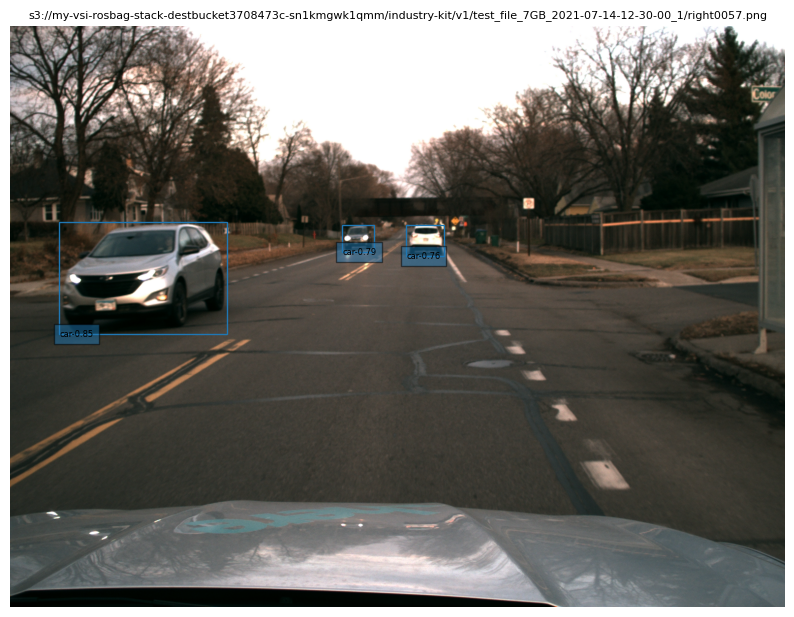

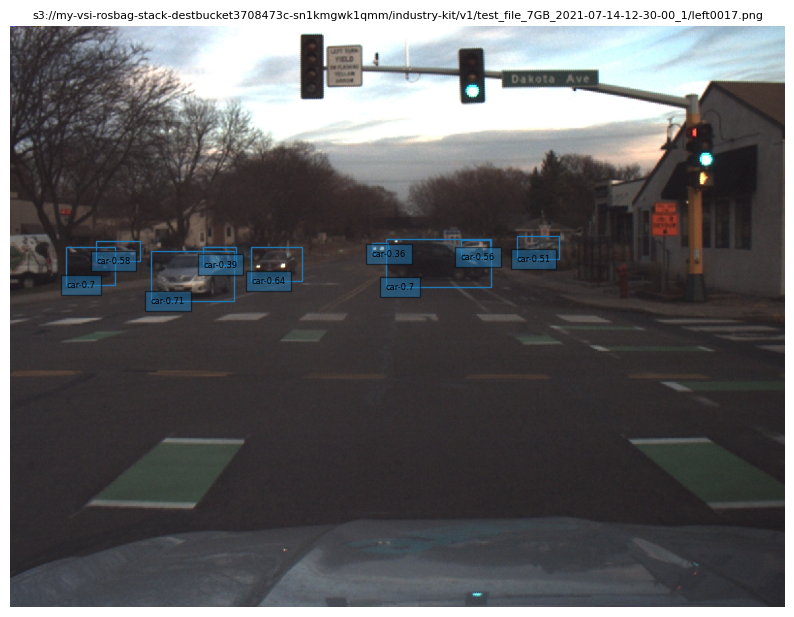

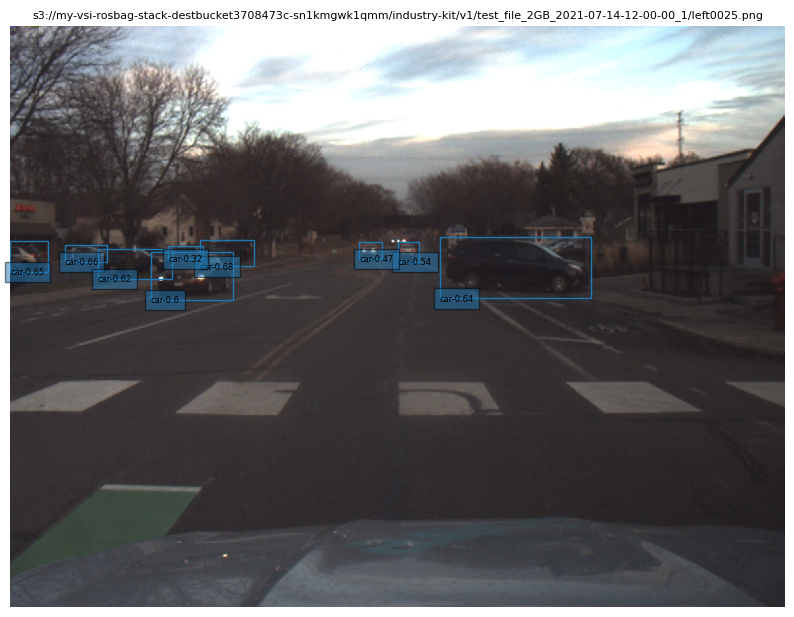

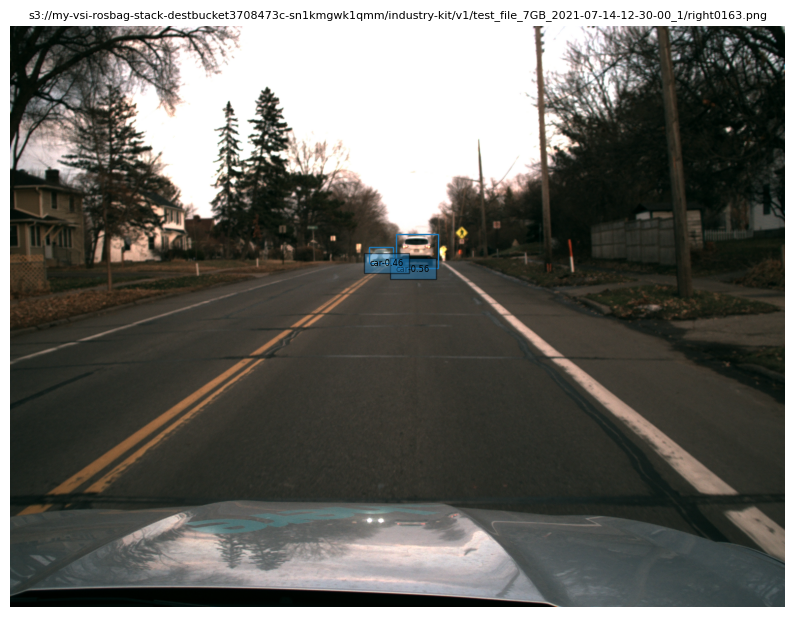

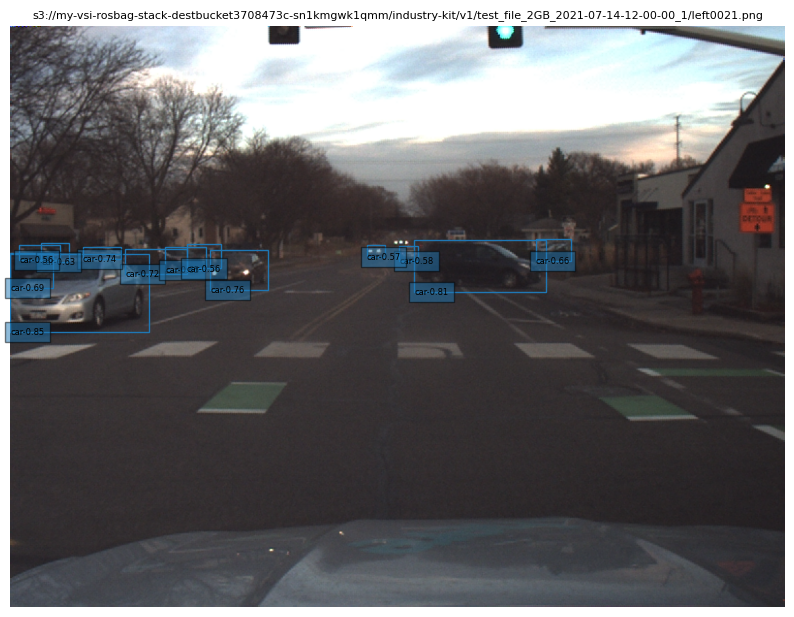

In [69]:
for row, img in enumerate(rand_images):
    fig, axes = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
    img.download("./img/raw-images/")
    axes.set_title(img.uri, fontdict={"fontsize": 8})
    img.plot_consolidated_bbs(axes)
    fig.savefig(
        "./img/labelled-images/" + "_".join(img.uri.split("/")[3::]),
        bbox_inches="tight",
    )

# Create RecordIO Format

Since we are happy with the annotation quality, we can continue and prepare the dataset for training.
The preferred Object Detection Format for GluonCV is based on LST file format, which is convertible to the [RecordIO design](https://mxnet.apache.org/versions/1.8.0/api/architecture/note_data_loading) that provides faster disk access and compact storage. GluonCV provides a [tutorial](https://cv.gluon.ai/build/examples_datasets/detection_custom.html) on how to convert a LST file format into a RecordIO file, thus we will not dive deep in this blogpost. 

In [70]:
file = "ground_truth/output.manifest"
train_lst = "data/train/train.lst"
val_lst = "data/val/val.lst"
test_lst = "data/test/test.lst"

In [71]:
with jsonlines.open(file, "r") as reader:
    lines = list(reader)
    # Shuffle data in place.
    np.random.shuffle(lines)

train_data, validation_data, test_data = np.split(
    lines, [int(0.6 * len(lines)), int(0.8 * len(lines))]
)

with open(train_lst, "w") as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write("\n")

with open(val_lst, "w") as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write("\n")

with open(test_lst, "w") as f:
    for line in test_data:
        f.write(json.dumps(line))
        f.write("\n")

print(
    "training samples: {}, validation samples: {}, test samples: {}".format(
        len(train_data), len(validation_data), len(test_data)
    )
)

training samples: 72, validation samples: 24, test samples: 24


In [72]:
def write_line(img_path, h, w, c, boxes, ids, idx):
    """does not account for empty images meaning no pedestrian in it"""
    # for header, we use minimal length 2, plus width and height
    # with A: 4, B: 5, C: width, D: height
    A = 4
    B = 5
    C = w
    D = h
    # concat id and bboxes
    labels = np.hstack((ids.reshape(-1, 1), boxes)).astype("float")
    # normalized bboxes (recommended)
    labels[:, (1, 3)] /= float(w)
    labels[:, (2, 4)] /= float(h)
    # flatten
    labels = labels.flatten().tolist()
    str_idx = [str(idx)]
    str_header = [str(x) for x in [A, B, C, D]]
    str_labels = [str(x) for x in labels]
    str_path = [img_path]
    line = "\t".join(str_idx + str_header + str_labels + str_path) + "\n"
    return line

In [73]:
with open(train_lst, "w") as fw:
    for idx, line in enumerate(train_data):
        all_boxes = []
        all_ids = []
        h, w = (
            line[job_name]["image_size"][0]["height"],
            line[job_name]["image_size"][0]["width"],
        )
        for item in line[job_name]["annotations"]:
            all_boxes.append(
                [
                    item["left"],
                    item["top"],
                    item["width"] + item["left"],
                    item["top"] + item["height"],
                ]
            )
            all_ids.append((item["class_id"]))
        line = write_line(
            line["source-ref"],
            h,
            w,
            line[job_name]["image_size"][0]["depth"],
            np.array(all_boxes),
            np.array(all_ids),
            idx,
        )
        fw.write(line)

In [74]:
with open(val_lst, "w") as fw:
    for idx, line in enumerate(validation_data):
        all_boxes = []
        all_ids = []
        h, w = (
            line[job_name]["image_size"][0]["height"],
            line[job_name]["image_size"][0]["width"],
        )
        for item in line[job_name]["annotations"]:
            all_boxes.append(
                [
                    item["left"],
                    item["top"],
                    item["width"] + item["left"],
                    item["top"] + item["height"],
                ]
            )
            all_ids.append((item["class_id"]))
        line = write_line(
            line["source-ref"],
            h,
            w,
            line[job_name]["image_size"][0]["depth"],
            np.array(all_boxes),
            np.array(all_ids),
            idx,
        )
        fw.write(line)

In [75]:
with open(test_lst, "w") as fw:
    for idx, line in enumerate(test_data):
        all_boxes = []
        all_ids = []
        h, w = (
            line[job_name]["image_size"][0]["height"],
            line[job_name]["image_size"][0]["width"],
        )
        for item in line[job_name]["annotations"]:
            all_boxes.append(
                [
                    item["left"],
                    item["top"],
                    item["width"] + item["left"],
                    item["top"] + item["height"],
                ]
            )
            all_ids.append((item["class_id"]))
        line = write_line(
            line["source-ref"],
            h,
            w,
            line[job_name]["image_size"][0]["depth"],
            np.array(all_boxes),
            np.array(all_ids),
            idx,
        )
        fw.write(line)

MXNet provides a tool called [im2rec.py](https://mxnet.apache.org/versions/1.8.0/api/faq/recordio) to convert LST files into the RecordIO file format. We slightly modified the script to read data from S3 instead of your local machine.

In [ ]:
os.system(
    "python ./ground_truth/im2rec.py ./data/train {} --pack-label --resize 512".format(
        job_name
    )
)

In [ ]:
os.system(
    "python ./ground_truth/im2rec.py ./data/val {} --pack-label --resize 512".format(
        job_name
    )
)

In [ ]:
os.system(
    "python ./ground_truth/im2rec.py ./data/test {} --pack-label --resize 512".format(
        job_name
    )
)

In the next step we will need to upload the data to S3 to use it for training:

In [ ]:
os.system("aws s3 cp ./data s3://{}/ --recursive".format(BUCKET))

# SageMaker Training
In order to train a customized neural network, we will use [Amazon SageMaker Script Mode](https://github.com/aws-samples/amazon-sagemaker-script-mode), allowing us to bring our own training algorithms while leveraging the simple UI of Amazon SageMaker. 
To do so, we need to specify paths where to e.g. store the output of the Training Job.

In [80]:
s3_output_path = "s3://{}/model".format(BUCKET)
s3_code_path = "s3://{}/customcode".format(BUCKET)

We can specify S3 paths that points towards the S3 folder path containing the .rec, .lst and .idx files

In [ ]:
training = "s3://{}/train".format(BUCKET)
validation = "s3://{}/val".format(BUCKET)
test = "s3://{}/test".format(BUCKET)

In [82]:
channels = {
    "train": TrainingInput(training),
    "val": TrainingInput(validation),
    "test": TrainingInput(test),
}

If you wish to log certain metrics such as mean Average Precision or Losses during the SageMaker Training, you need to add the Regex as a parameter **metric_definitions** when creating the Estimator:

In [83]:
metric_definitions = [
    {"Name": "val:car mAP", "Regex": "val:mAP=(.*?),"},
    {"Name": "test:car mAP", "Regex": "test:mAP=(.*?),"},
    {"Name": "BoxCenterLoss", "Regex": "BoxCenterLoss=(.*?),"},
    {"Name": "ObjLoss", "Regex": "ObjLoss=(.*?),"},
    {"Name": "BoxScaleLoss", "Regex": "BoxScaleLoss=(.*?),"},
    {"Name": "ClassLoss", "Regex": "ClassLoss=(.*?),"},
]

Next we will need to create the Estimator, providing the entry_point script and specify instance types. 

In [84]:
model_estimator = MXNet(
    entry_point="train_yolov3.py",
    role=role,
    instance_count=1, # value can be more than 1 for multi node training
    instance_type="ml.p3.8xlarge",
    framework_version="1.8.0",
    metric_definitions=metric_definitions,
    output_path=s3_output_path,
    code_location=s3_code_path,
    py_version="py37")

# Hyperparameter optimization 
While training neural networks there are lots of parameters that can be optimised to the use case and the custom dataset, which we usually refer to as [automatic model tuning in SageMaker](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/)or hyperparameter optimisation. Amazon SageMaker will launch multiple training jobs with a unique combination of hyperparameters and searches the best configuration achieving the highest mean average precision (mAP) on our held-out test data. 

In the following cell we will specify the ranges of the hyperparameters we want to optimize, as well as which objective metric should be monitored while selecting the best hyperparameter configuration. You can select every objective_metric that is logged in your training script.

In [85]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "wd": ContinuousParameter(0.0001, 0.001),
    "epochs": IntegerParameter(5,6),
}
objective_metric_name = "val:car mAP"

In [86]:
%%time
hpo_tuner = HyperparameterTuner(
    model_estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,  # maximum jobs that should be ran
    max_parallel_jobs=2, # maximum jobs that will be executed in parallel
    base_tuning_job_name="yolov3",
)

hpo_tuner.fit(channels)

..........................................................................................!
CPU times: user 555 ms, sys: 0 ns, total: 555 ms
Wall time: 7min 34s


# Model Compilation with SageMaker Neo
While for training in the cloud we don’t have hard constraints for model environment, we do need to bear in mind the production environment when running inference with trained models: no powerful GPUs and limited storage are common challenges. Amazon has a service called [Amazon SageMaker Neo](https://aws.amazon.com/sagemaker/neo/) that allows you to train once and run anywhere in the cloud and at the edge with optimal performance while reducing the memory footprint of your model! SageMaker Neo optimises models to run up to twice as fast, with no loss in accuracy for a specific hardware type. 

What does Neo do under the hood? Neo converts your model (e.g. json file) into an efficient common format: it simplifies and changes the computational graph of a machine learning model by e.g. combining and reducing the number of transformations. To compile the model with Neo we need to provide information such as the input size of the data, the framework and the target instance.

In [87]:
%%time

best_estimator =hpo_tuner.best_estimator()
compiled_model = best_estimator.compile_model(
    target_instance_family="ml_c4",
    role=role,
    input_shape={"data": [1, 3, 512, 512]},
    output_path=s3_output_path,
    framework="mxnet",
    framework_version="1.8",
    env={
        "MMS_DEFAULT_RESPONSE_TIMEOUT": "500" }
)


2021-07-15 15:27:45 Starting - Preparing the instances for training
2021-07-15 15:27:45 Downloading - Downloading input data
2021-07-15 15:27:45 Training - Training image download completed. Training in progress.
2021-07-15 15:27:45 Uploading - Uploading generated training model
2021-07-15 15:27:45 Completed - Training job completed
?????????????????????....................................!CPU times: user 331 ms, sys: 0 ns, total: 331 ms
Wall time: 4min 51s


# Deploy endpoint
Deploying a model requires a few additional lines of code for hosting such as `model_fn` and `transform_fn` in the `train_yolov3.py` script. Bear in mind that the `target_instance_family` of your compilation job and the endpoint `instance_type` should match. 

In [88]:
%%time

predictor = compiled_model.deploy(
    initial_instance_count=1, instance_type="ml.c4.xlarge", endpoint_name="YOLO-DEMO-endpoint", deserializer=JSONDeserializer(),serializer=JSONSerializer()
)

-------------!CPU times: user 35.1 s, sys: 4.43 s, total: 39.5 s
Wall time: 7min 8s


# Test predictions
Once the model is deployed with an endpoint, we can test inference with some sample images. To do so we will use the function below, drawing a bounding box around the prediction and displaying object name and the confidence score associated with the prediction.

In [89]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6, data_shape=512):
        """
        visualize detections in one image
        Parameters:
        ----------
        img_file : numpy.array
            image, in bgr format
        dets : numpy.array
            yolo detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        data_shape : integer
            size of the image
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        from matplotlib.patches import Rectangle
        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        klasses = dets[0][0]
        scores = dets[1][0]
        bbox = dets[2][0]
        for i in range(len(classes)):
            klass = klasses[i][0]
            score = scores[i][0]
            x0, y0, x1, y1 = bbox[i]
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width / data_shape)
            ymin = int(y0 * height / data_shape)
            xmax = int(x1 * width / data_shape)
            ymax = int(y1 * height / data_shape)
            rect = Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin-2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.tight_layout(rect=[0, 0, 2, 2])
        plt.show()

Now we can test the model on some example images. Therefore we can download some images from our S3 Bucket, or you can upload your images into the directory `./img/test-images/`

In [ ]:
os.system("aws s3 cp s3://{}/industry-kit/v1/test_file_7GB_{}/left0180.png ./img/test-images/left0180.png ".format(s3_bucket_raw_images, s3_folder_raw_images_7GB))
os.system("aws s3 cp s3://{}/industry-kit/v1/test_file_7GB_{}/right0152.png ./img/test-images/right0152.png ".format(s3_bucket_raw_images, s3_folder_raw_images_7GB))
os.system("aws s3 cp s3://{}/industry-kit/v1/test_file_7GB_{}/left0137.png ./img/test-images/left0137.png ".format(s3_bucket_raw_images, s3_folder_raw_images_7GB))
os.system("aws s3 cp s3://{}/industry-kit/v1/test_file_7GB_{}/left0100.png ./img/test-images/left0100.png ".format(s3_bucket_raw_images, s3_folder_raw_images_7GB))

In [166]:
object_categories = ["car"] # list of objects to detect
threshold = 0.2  # confidence threshold for the prediction of your model 
directory = "./img/test-images/"  # folder directory of your images you want to use for test predictions

left0180.png


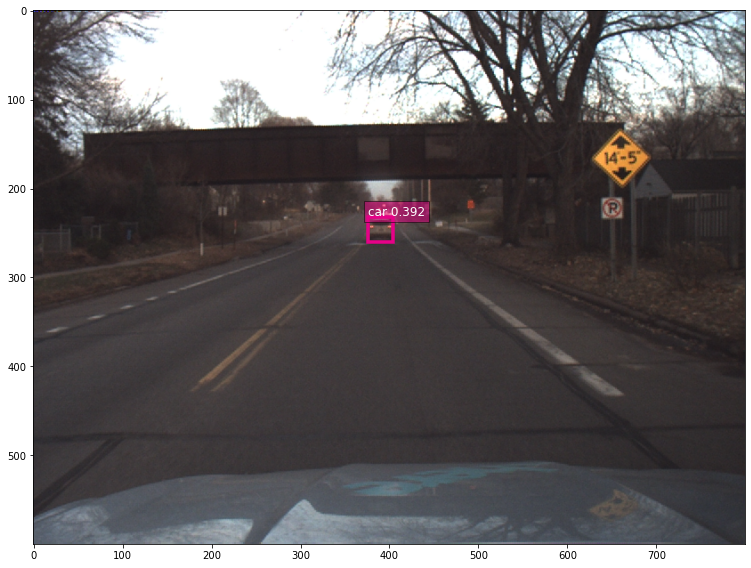

left0100.png


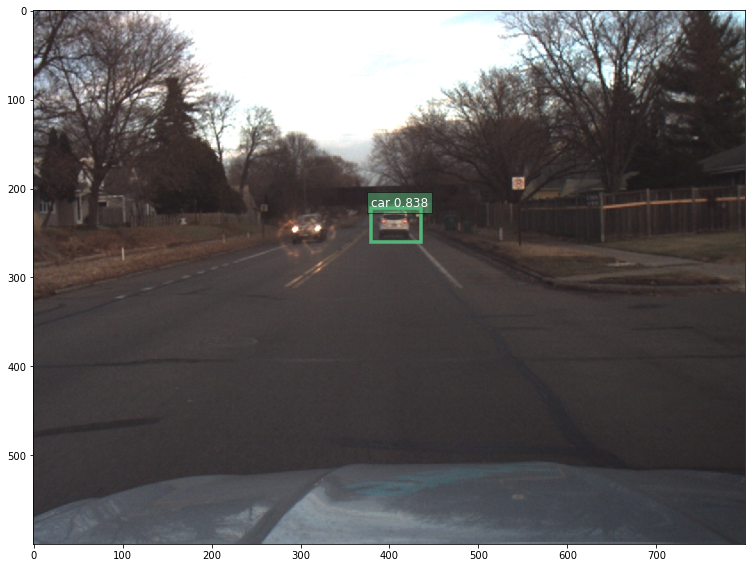

right0152.png


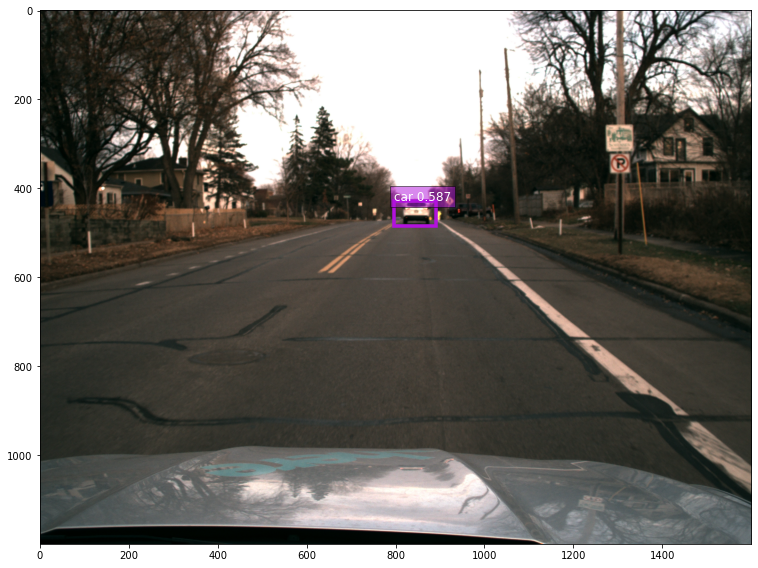

left0137.png


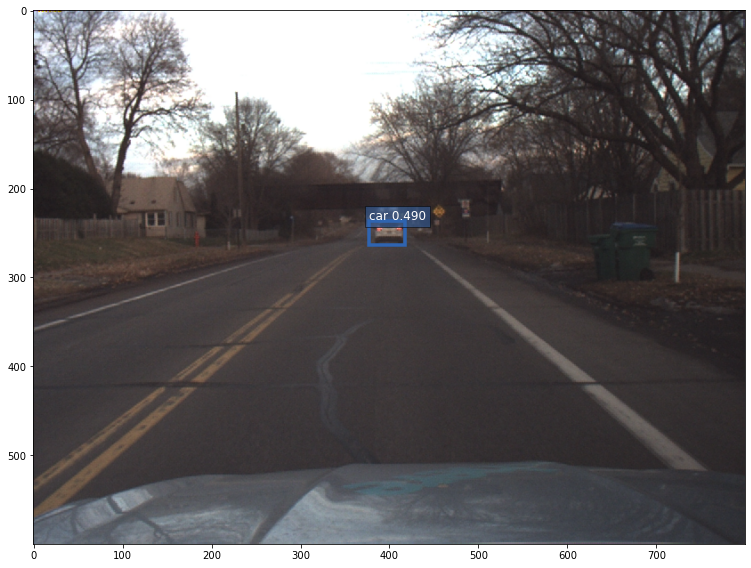

In [167]:
for file_name in os.listdir(directory):
    print(file_name)
    test_image = PIL.Image.open(os.path.join(directory, file_name))
    test_image = np.asarray(test_image.resize((512, 512))) 
    endpoint_response = predictor.predict(test_image)
    visualize_detection(os.path.join(directory, file_name), endpoint_response, object_categories, threshold)